<a href="https://colab.research.google.com/github/abhishekrathoreiitb/maven-project/blob/master/RAG_Insurance_Abhishek.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HelpMate AI - A Generative Search System for Insurance Policies
*by Abhishek Rathore*

Insurance policy documents are notoriously dense, complex, and difficult for average
users to understand. Customers often struggle to find specific information about their
coverage, eligibility, claim procedures, exclusions, and other crucial details. Traditional
keyword search methods are often inadequate, as they fail to capture the semantic
meaning of the user's query and the nuances of the policy language. This leads to
frustration, wasted time, and potentially incorrect interpretations of the policy. The
problem is exacerbated when users need to compare information across multiple
policy documents or versions.

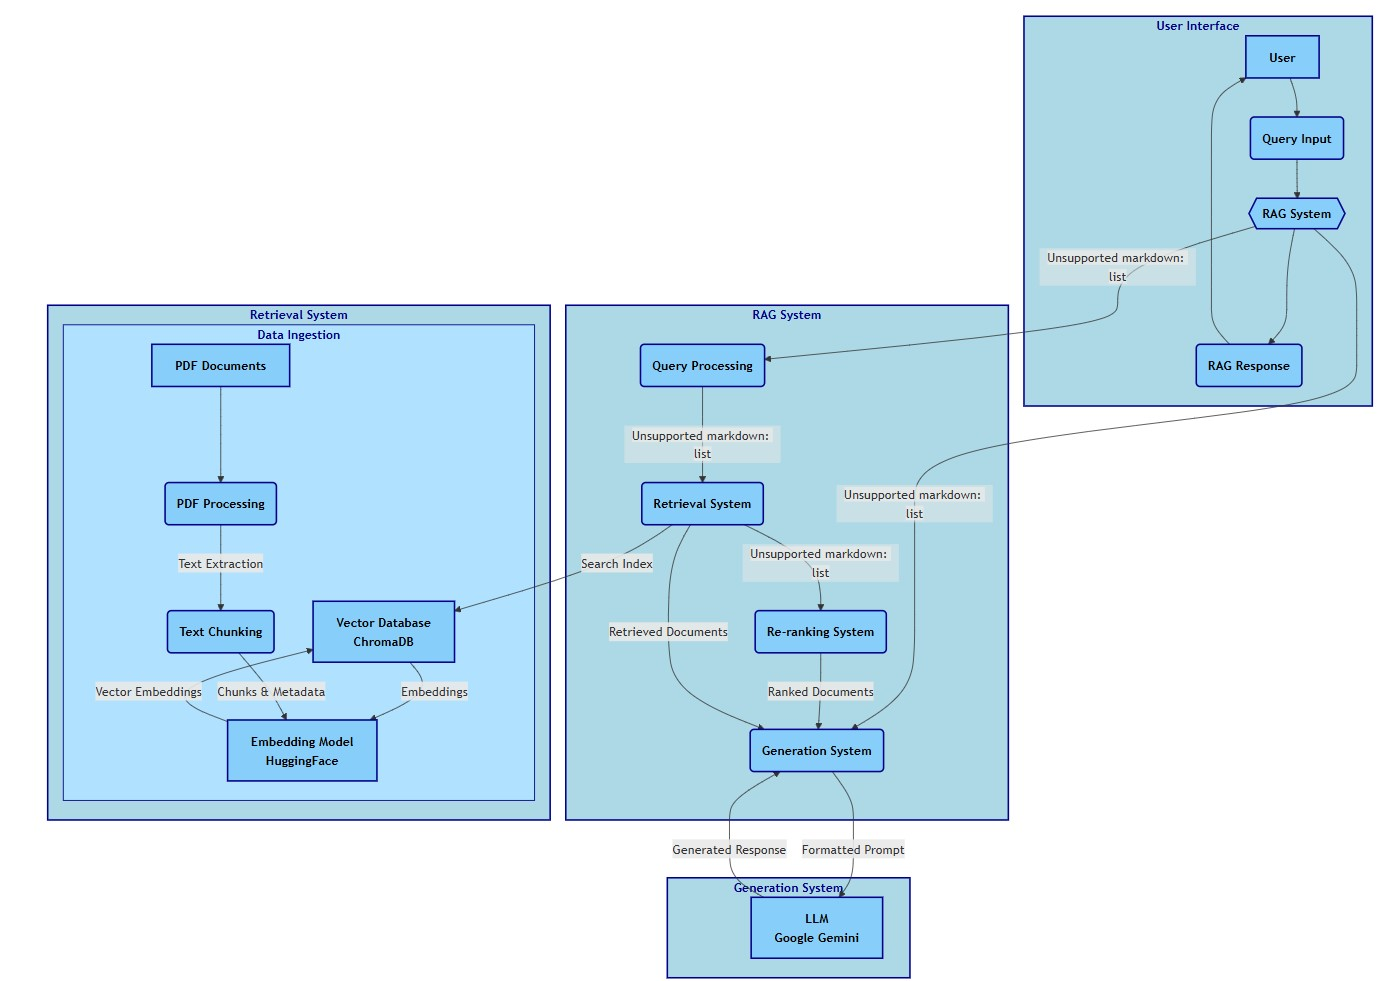

Install Libraries

In [26]:
# Install necessary libraries from requirements.txt
"""
google-generativeai==0.8.4
google-ai-generativelanguage==0.6.15
llama-index
chromadb
sentence-transformers
pypdf2
langchain
llama-index-llms-gemini
llama-index-llms-huggingface
llama-index-embeddings-huggingface
llama-index-vector-stores-chroma
langchain-community
langchain-google-genai

"""
!pip install -r requirements.txt

In [2]:
#!pip install llama-index --upgrade

In [3]:
import os
import textwrap
import pathlib

from llama_index.core import (
        VectorStoreIndex,
        SimpleDirectoryReader,
        ServiceContext,
        StorageContext,
    )
from llama_index.llms.gemini import Gemini
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.vector_stores.chroma.base import ChromaVectorStore
from llama_index.core.node_parser import SentenceSplitter
from llama_index.core.schema import MetadataMode
from llama_index.core.prompts.prompts import SimpleInputPrompt

from llama_index.core import VectorStoreIndex,SimpleDirectoryReader,ServiceContext,PromptTemplate,Settings
from llama_index.llms.huggingface import HuggingFaceLLM

import chromadb
from chromadb.utils import embedding_functions
# For LangChain
from langchain.embeddings import HuggingFaceEmbeddings
from langchain_google_genai import ChatGoogleGenerativeAI
from sentence_transformers import CrossEncoder
import pandas as pd
from PyPDF2 import PdfReader
# For Collab specific
from google.colab import files
import google.colab

### 1. API Key Setup (Colab-Specific - Using Secrets Manager)

In [4]:
from google.colab import userdata

try:
  GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
  if GOOGLE_API_KEY is None:
    raise ValueError("GOOGLE_API_KEY not found in Colab Secrets. Please add it.")
except Exception as e:
  print(f"Error accessing secret: {e}")
  print("Please ensure you've set up the GOOGLE_API_KEY secret in Colab.")
  GOOGLE_API_KEY = input("Please enter your Google API Key:") # Assign a value to GOOGLE_API_KEY if retrieval fails

os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

#### 2.  PDF Loading and Processing

In [8]:
# Colab-Specific

def upload_files():
    """Handles file uploads in Google Colab.

    Returns:
        list: A list of filenames of the uploaded files.
    """
    uploaded = files.upload()
    return list(uploaded.keys()) # returns a list of filenames

def process_pdf(pdf_path: str):
    """Reads a PDF, extracts text and metadata from each page.

    Args:
        pdf_path (str): The path to the PDF file.

    Returns:
        list: A list of dictionaries, where each dictionary represents a page
              and contains the 'text' and 'metadata'.
    """
    reader = PdfReader(pdf_path)
    documents = []
    for page_num in range(len(reader.pages)):
        page = reader.pages[page_num]
        text = page.extract_text()
        metadata = {
            "page_number": page_num + 1,
            "file_name": os.path.basename(pdf_path),
        }
        documents.append({"text": text, "metadata": metadata})
    return documents


def process_uploaded_pdfs(filenames):
    """Processes multiple PDF files uploaded to Colab.

    Args:
        filenames (list): A list of filenames of PDF files.

    Returns:
        list: A list of dictionaries, each representing a page from all
              the uploaded PDFs, with 'text' and 'metadata'.
    """
    all_docs = []
    for filename in filenames:
        all_docs.extend(process_pdf(filename))
    return all_docs

### 3. Document Chunking

In [7]:
def chunk_documents(documents, chunk_size=500, chunk_overlap=50):
    """Chunks documents using SentenceSplitter.

    Args:
        documents (list): A list of dictionaries, each with 'text' and 'metadata'.
        chunk_size (int): The maximum number of characters in each chunk.
        chunk_overlap (int): The number of overlapping characters between chunks.

    Returns:
        list: A list of dictionaries, each representing a text chunk with
              'text' and 'metadata'.
    """
    text_parser = SentenceSplitter(
        chunk_size=chunk_size, chunk_overlap=chunk_overlap
    )
    chunked_documents = []
    for doc in documents:
        text_chunks = text_parser.split_text(doc["text"])
        for chunk in text_chunks:
            chunked_documents.append({"text": chunk, "metadata": doc["metadata"].copy()})
    return chunked_documents

### 4. Generating Embeddings & ChromaDB Storage

In [9]:
def create_index(chunked_documents, model_name="BAAI/bge-small-en-v1.5"):
    """Creates and populates the ChromaDB index using Settings.

    Args:
        chunked_documents (list): A list of dictionaries, each representing a
                                  text chunk with 'text' and 'metadata'.
        model_name (str): The name of the HuggingFace embedding model to use.

    Returns:
        tuple: A tuple containing the VectorStoreIndex and the Settings object.
    """
    db = chromadb.Client()
    chroma_collection = db.get_or_create_collection("insurance_policies")
    vector_store = ChromaVectorStore(chroma_collection=chroma_collection)
    storage_context = StorageContext.from_defaults(vector_store=vector_store)

    # Use Settings to configure LLM and Embedding Model
    embed_model = HuggingFaceEmbedding(model_name=model_name)
    llm = Gemini(model_name="models/gemini-2.0-flash", google_api_key=GOOGLE_API_KEY)
    Settings.llm = llm
    Settings.embed_model = embed_model
    Settings.chunk_size = 500 # Set chunk size globally

    import llama_index
    index = VectorStoreIndex.from_documents(
        [
            llama_index.core.schema.Document(text=doc["text"], metadata=doc["metadata"])
            for doc in chunked_documents
        ],
        storage_context=storage_context,
        show_progress=True,
    )
    return index, Settings

### 5. Semantic Search with Cache

In [10]:
def semantic_search(index, query_str, service_context, similarity_top_k=5):
    """Performs semantic search using the given index.

    Args:
        index (VectorStoreIndex): The LlamaIndex vector store index.
        query_str (str): The user's query string.
        settings (Settings):  The LlamaIndex settings object
        similarity_top_k (int): The number of most similar documents to retrieve.

    Returns:
        tuple: A tuple containing a list of search results (dictionaries with
               'score', 'text', and 'metadata') and the raw response object.
    """
    query_engine = index.as_query_engine(
        similarity_top_k=similarity_top_k, service_context=service_context
    )
    response = query_engine.query(query_str)
    results = []
    for node in response.source_nodes:
        results.append(
            {
                "score": node.score,
                "text": node.get_content(metadata_mode=MetadataMode.NONE),
                "metadata": node.metadata,
            }
        )
    return results, response.response

### 6. Re-Ranking with a Cross Encoder

In [14]:
def rerank_results(results, query_str, model_name="cross-encoder/ms-marco-MiniLM-L-6-v2"):
    """Re-ranks search results using a cross-encoder.

    Args:
        results (list): A list of search results from semantic_search.
        query_str (str): The user's query string.
        model_name (str): The name of the cross-encoder model to use.

    Returns:
        list: A list of re-ranked search results, sorted by cross-encoder score.
    """
    if not results:
        return []
    cross_encoder = CrossEncoder(model_name)
    pairs = [[query_str, result["text"]] for result in results]
    scores = cross_encoder.predict(pairs)
    for i, score in enumerate(scores):
        results[i]["cross_encoder_score"] = score
    reranked_results = sorted(results, key=lambda x: x["cross_encoder_score"], reverse=True)
    return reranked_results

### 7. Retrieval Augmented Generation (RAG)

In [15]:
def rag_response(query_str, reranked_results, service_context, context_window=3):
    """Generates a response using RAG.

    Args:
        query_str (str): The user's query string.
        reranked_results (list): A list of re-ranked search results.
        settings (Settings): The LlamaIndex settings object.
        context_window (int): The number of top results to use as context.

    Returns:
        str: The generated response from the LLM.
    """
    if not reranked_results:
        return "No relevant information found in the documents."

    context_str = "\n\n".join(
        [result["text"] for result in reranked_results[:context_window]]
    )

    qa_template = """
    Context information is below.
    ---------------------
    {context_str}
    ---------------------
    Given the context information and not prior knowledge, answer the query.
    Query: {query_str}
    Answer:
    """
    qa_prompt = SimpleInputPrompt(qa_template)
    formatted_prompt = qa_prompt.format(context_str=context_str, query_str=query_str)

    # Use LangChain's Gemini for RAG
    llm = ChatGoogleGenerativeAI(model="models/gemini-2.0-flash", google_api_key=GOOGLE_API_KEY, temperature=0.1)
    response = llm.invoke(formatted_prompt)
    return response

### 8. Main Query Function

In [16]:
def answer_query(index, query_str, service_context, rerank=True, rag=True):
    """Combines search, re-ranking, and RAG to answer a query.

    Args:
        index (VectorStoreIndex): The LlamaIndex vector store index.
        query_str (str): The user's query string.
        settings (Settings): The LlamaIndex settings object.
        rerank (bool): Whether to use the cross-encoder for re-ranking.
        rag (bool): Whether to use RAG for generating the response.

    Returns:
        str: The final response (either from RAG or a message indicating
             that no relevant documents were found or RAG is disabled).
    """
    search_results, raw_llm_response = semantic_search(index, query_str, service_context)
    if not search_results:
        return "No relevant documents found.", [], ""
    if rerank:
        reranked_results = rerank_results(search_results, query_str)
    else:
        reranked_results = search_results

    if rag:
        final_response = rag_response(query_str, reranked_results, service_context)
    else:
        final_response = raw_llm_response

    return final_response, reranked_results, raw_llm_response

### 9.  Example Usage (Colab-Specific)

In [17]:
# 1. Upload PDFs
filenames = upload_files()

Saving life_insurance_max.pdf to life_insurance_max.pdf


In [18]:
# 2. Load and Process Documents
all_documents = process_uploaded_pdfs(filenames)

In [19]:
# 3. Chunk Documents
chunked_docs = chunk_documents(all_documents)

In [20]:
# 4. Create Index
index, service_context = create_index(chunked_docs)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/94.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

<ipython-input-9-fa9db35b932e>:19: DeprecationWarning: Call to deprecated class Gemini. (Should use `llama-index-llms-google-genai` instead, using Google's latest unified SDK. See: https://docs.llamaindex.ai/en/stable/examples/llm/google_genai/)
  llm = Gemini(model_name="models/gemini-2.0-flash", google_api_key=GOOGLE_API_KEY)


Parsing nodes:   0%|          | 0/37 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/37 [00:00<?, ?it/s]

In [21]:
# 5. Run Queries
query = "What is the Eligibility?"
final_answer, retrieved_results, raw_answer = answer_query(index, query, service_context)
print(f"RAG Answer:\n{final_answer}\n")
print(f"Raw Answer:\n{raw_answer}\n")
print("Retrieved Documents (with scores):")
for result in retrieved_results:
    print(f"  Score: {result['score']:.3f}, Cross-Encoder Score: {result.get('cross_encoder_score', 'N/A'):.3f}")
    print(f"  File: {result['metadata']['file_name']}, Page: {result['metadata']['page_number']}")
    print(f"  Text: {result['text'][:200]}...\n")

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

RAG Answer:
content='Based on the provided text, here\'s what constitutes "Eligibility":\n\n*   **For a Person to be a Member (Section 2.1.1):**\n\n    *   Must be a natural person.\n    *   Must be between 15 and 69 years of age (inclusive) on the Date of Commencement of Risk / Effective Date of Coverage or the Entry Date, and not more than 70 years old when the insurance expires.\n    *   The proposed Period of Coverage on the Date of Commencement of Risk / Effective Date of Coverage or the Entry Date must be at least 1 year.\n    *   Must meet the eligibility requirements as specified in Section 2.1 of this Policy and the Schedule, to participate in the Insurance under this Policy.\n\n*   **Eligibility Criteria for Admission to the Group (Page 4):**\n\n    *   There must be a clear relationship between individual Members and the Master Policyholder.\n    *   The Master Policyholder would be the authorized person to act on behalf of all Members of the group for the purpose of this Po

### 10. Interactive Query Loop

In [22]:
def interactive_query_loop(index, service_context):
    """Allows interactive querying with the RAG system.

    Args:
        index (VectorStoreIndex):  The LlamaIndex vector store index.
        settings (Settings): The LlamaIndex settings object.

    """
    while True:
        query = input("Enter your query (or type 'exit' to quit): ")
        if query.lower() == "exit":
            break
        final_answer, retrieved_results, raw_answer = answer_query(index, query, service_context)
        print(f"RAG Answer:\n{final_answer}\n")
        print(f"Raw LLM Answer (before RAG):\n{raw_answer}\n")
        print("Retrieved Documents (with scores):")
        for result in retrieved_results:
            print(
                f"  Score: {result['score']:.3f}, Cross-Encoder Score: {result.get('cross_encoder_score', 'N/A'):.3f}"
            )
            print(f"  File: {result['metadata']['file_name']}, Page: {result['metadata']['page_number']}")
            print(f"  Text: {result['text'][:200]}...\n")

In [23]:
interactive_query_loop(index, service_context)

Enter your query (or type 'exit' to quit): what is the coverage?
RAG Answer:
content='The coverage is the insurance cover effected on the lives of the Members under this Policy.' additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []} id='run-b6b37b46-d7dc-4dbd-a7de-3bca5d833314-0' usage_metadata={'input_tokens': 998, 'output_tokens': 18, 'total_tokens': 1016, 'input_token_details': {'cache_read': 0}}

Raw LLM Answer (before RAG):
The coverage is the insurance cover effected on the lives of the Members under this Policy.


Retrieved Documents (with scores):
  Score: 0.499, Cross-Encoder Score: 0.809
  File: life_insurance_max.pdf, Page: 7
  Text: “Period of Coverage ” means the period specified in the Certificate of Insurance , during which the 
Insurance on the life of a Member continues  under this Policy ; 
xxi. “Policy ” means “Group Credi...

  Score: 0.436, Cross-Encoder Score: -7.652
  F

In [24]:
def simple_interactive_query_loop(index, settings):
    """Allows interactive querying."""
    while True:
        query = input("Enter your query (or type 'exit' to quit): ")
        if query.lower() == "exit":
            break
        final_answer = answer_query(index, query, settings)  # Get the RAG answer

        if isinstance(final_answer, tuple) and len(final_answer) > 0:
            email_content = final_answer[0].content  # Extract the content from the AIMessage
            print(f"RAG Answer:\n{email_content}\n")
        else:
            print(f"RAG Answer:\n{final_answer}\n")

In [25]:
simple_interactive_query_loop(index, service_context)

Enter your query (or type 'exit' to quit): what is the coverage of the policy?
RAG Answer:
Based on the provided context, the coverage of the policy is the "Sum Assured," which is the sum payable by the insurer upon the death of a Member during the Period of Coverage. The specific amount is determined in accordance with Section 3 and is based on the Death Benefit Option chosen by the Master Policyholder, as indicated in the Schedule.

Enter your query (or type 'exit' to quit): How to claim?
RAG Answer:
Based on the provided text, here's how to claim:

1.  **Notify Max Life Insurance in Writing:** The Master Policyholder must notify Max Life Insurance in writing of the Insured Event (death) within 30 days of it happening. The notification should be sent to the address provided:

    Max Life Insurance Company Limited,

    Operations Centre, Claims Unit,

    Plot 90A, Sector 18, HUDA, Gurugram 122002,

    Haryana, India.

2.  **Provide Proof and Documents:** Upon receipt of satisfacto